In [17]:
import torch
from model import UNet
from dataset import RetinaDataset
from utils import load_data
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
import warnings

warnings.filterwarnings("ignore")

EXP_ID = 18808

MODEL_PATH = f"/scratch/y.aboelwafa/Retina/Retina_Blood_Vessel_Segmentation/checkpoints/pytorch_{EXP_ID}.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))

<All keys matched successfully>

In [18]:
show_imgs = 10
test_transform = A.Compose(
    [
        A.Resize(512, 512),
    ]
)
train_images, train_masks, test_images, test_masks = load_data("dataset")
test_dataset = RetinaDataset(test_images, test_masks, transform=test_transform)

In [29]:
def connected_components(img, min_threshold=0.2, max_threshold=0.4):

    _, sure_edges = cv2.threshold(img, max_threshold, 1, cv2.THRESH_BINARY)

    uncertain_edges = np.logical_and(img > min_threshold, img < max_threshold).astype(
        np.uint8
    )

    num_sure, sure_labels = cv2.connectedComponents(
        sure_edges.astype(np.uint8), connectivity=8
    )

    num_uncertain, uncertain_labels = cv2.connectedComponents(
        uncertain_edges, connectivity=8
    )
    
    combined = sure_labels.copy()
    
    for label in range(1, num_uncertain):
        uncertain_mask = (uncertain_labels == label)
        sure_neighbors = sure_labels[uncertain_mask]
        sure_neighbors = sure_neighbors[sure_neighbors > 0]
        
        if len(sure_neighbors) > 0:
            combined[uncertain_mask] = np.bincount(sure_neighbors.flatten()).argmax()
        
    
    combined[combined > 0] = 1
    
    return num_sure, sure_labels, num_uncertain, uncertain_labels, combined

### Report on the `connected_components` Function

The function is based on the **hysteresis thresholding** technique. <br>
The function takes an image and two threshold values as input and performs the following steps:

1. Identifies "sure" and "uncertain" edges in the image based on the threshold values.
2. Labels connected components within these regions (sure regions & uncertain regions).
3. Combines the labels of uncertain regions with their neighboring sure regions if overlaped with them using masks.

#### Function Details

1. **Identifying Sure Edges**:
    
    ```python
    _, sure_edges = cv2.threshold(img, max_threshold, 1, cv2.THRESH_BINARY)
    ```
    - Applies a binary threshold to the image `img` using `max_threshold`. <br> 
    Pixels with values above `max_threshold` are considered "sure" edges and are set to 1, while others are set to 0.

2. **Identifying Uncertain Edges**:
    ```python
    uncertain_edges = np.logical_and(img > min_threshold, img < max_threshold).astype(np.uint8)
    ```
    - Identifies pixels that fall between `min_threshold` and `max_threshold`. <br>
     These pixels are considered "uncertain" edges and are set to 1, while others are set to 0.

3. **Labeling Sure Components**:
    ```python
    num_sure, sure_labels = cv2.connectedComponents(sure_edges.astype(np.uint8), connectivity=8)
    ```
    - Labels connected components in the `sure_edges` binary image. <br>
    Each connected component is assigned a unique label. <br>
    The total number of sure components is stored in `num_sure`, and the labeled image is stored in `sure_labels`.

4. **Labeling Uncertain Components**:
    ```python
    num_uncertain, uncertain_labels = cv2.connectedComponents(uncertain_edges, connectivity=8)
    ```
    - Labels connected components in the `uncertain_edges` binary image. <br>
    Each connected component is assigned a unique label. <br>
    The total number of uncertain components is stored in `num_uncertain`, and the labeled image is stored in `uncertain_labels`.

5. **Combining Sure and Uncertain Components**:
    ```python
    combined = sure_labels.copy()
    ```
    - Creates a copy of the `sure_labels` image to store the combined labels.

6. **Filter Uncertain Components**:
    
    ```python
    for label in range(1, num_uncertain):
        uncertain_mask = (uncertain_labels == label)
        sure_neighbors = sure_labels[uncertain_mask]
        sure_neighbors = sure_neighbors[sure_neighbors > 0]
        
        if len(sure_neighbors) > 0:
            combined[uncertain_mask] = np.bincount(sure_neighbors.flatten()).argmax()
    ```
    Iterates through each uncertain component. For each component:
    - Creates a mask `uncertain_mask` to isolate the current uncertain component.
    - Identifies neighboring sure components by checking the overlap between it and the `sure_labels`.
    - If there are neighboring sure components, assigns the most frequent sure label to the uncertain component in the `combined` image.

7. **Binarizing the Combined Image**:
    
    ```python
    combined[combined > 0] = 1
    ```
    - Converts the combined labels to a binary image where all labeled regions are set to 1.

#### References
- [Hysteresis Thresholding](https://www.youtube.com/watch?v=sRFM5IEqR2w&t=255s&pp=ygUXaHlzdGVyZXNpcyB0aHJlc2hvbGRpbmc%3D)
- [Thresholding in OpenCV](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
- [Numpy bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html)



Number of sure components =  29
Number of uncertain components =  2680
IoU Score before hysteresis thresholding =  0.7247858047485352


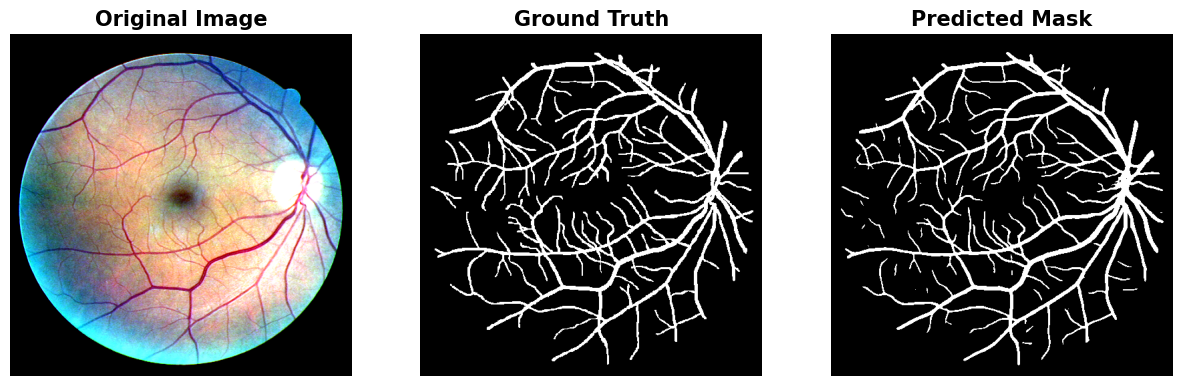

IoU Score after hysteresis thresholding =  0.7256941795349121


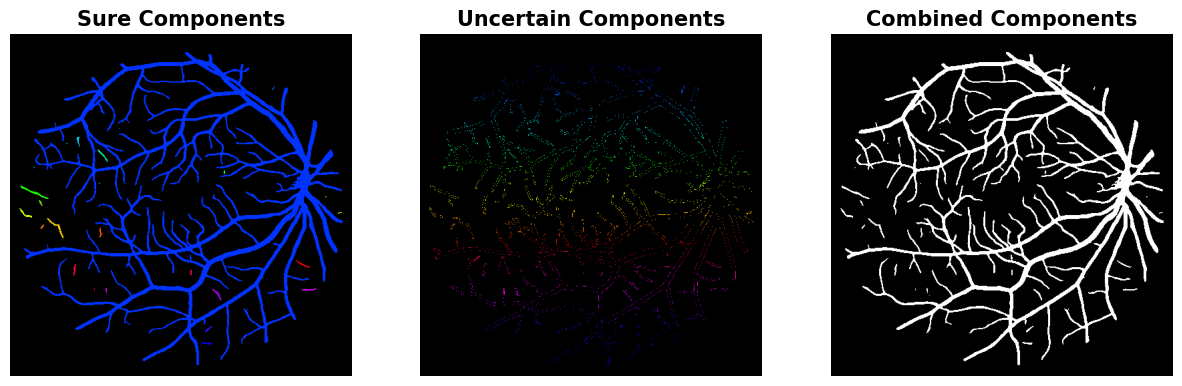

Number of sure components =  22
Number of uncertain components =  2200
IoU Score before hysteresis thresholding =  0.6941300630569458


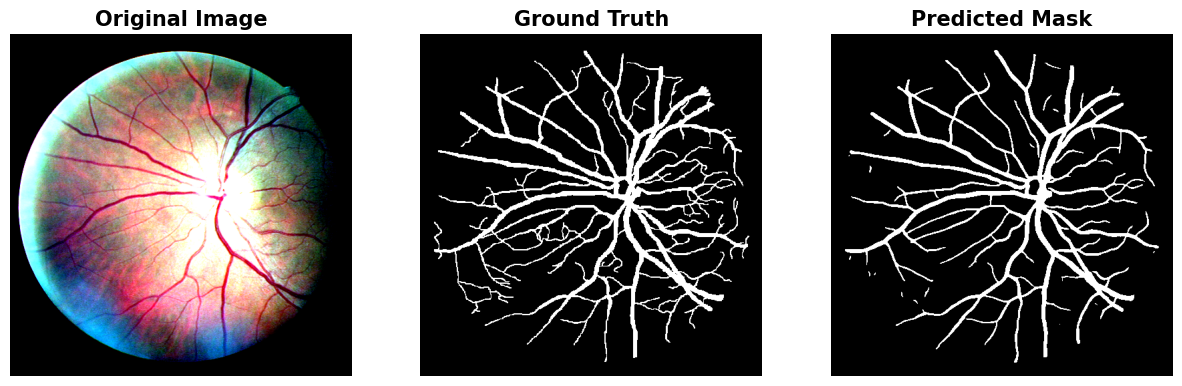

IoU Score after hysteresis thresholding =  0.7003594636917114


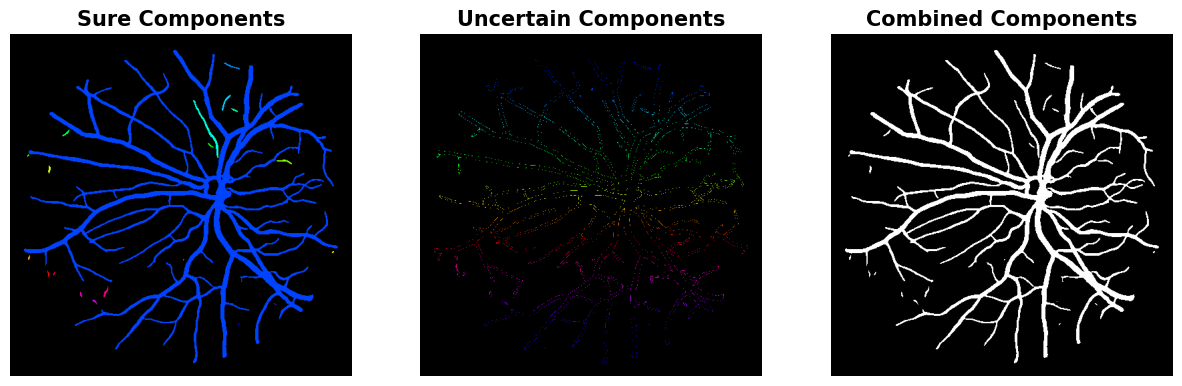

Number of sure components =  36
Number of uncertain components =  2428
IoU Score before hysteresis thresholding =  0.6952144503593445


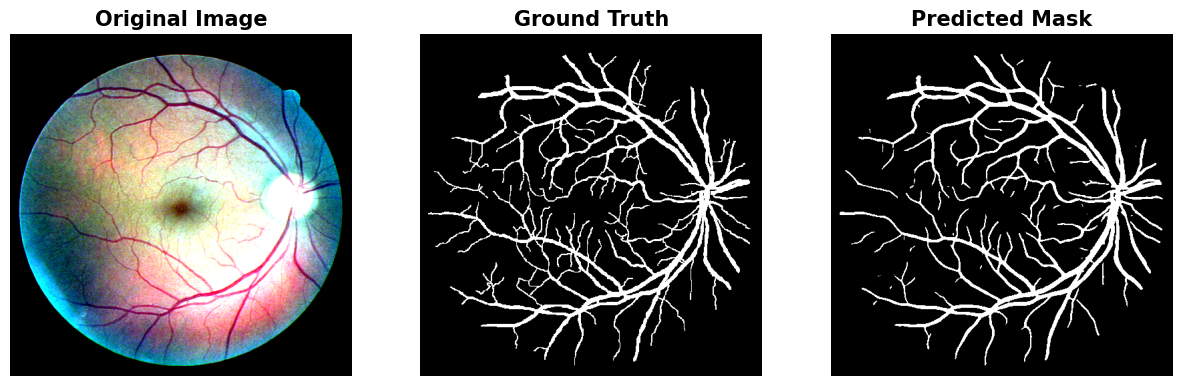

IoU Score after hysteresis thresholding =  0.6950402855873108


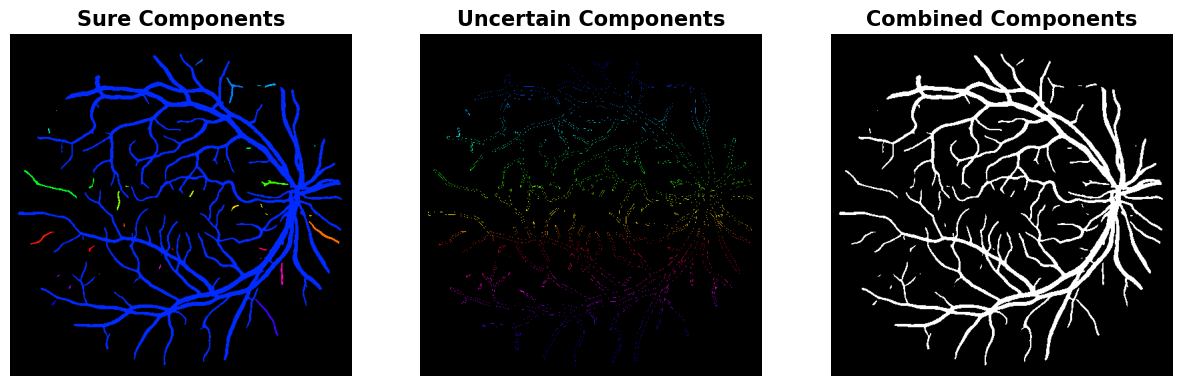

Number of sure components =  32
Number of uncertain components =  2348
IoU Score before hysteresis thresholding =  0.6679803133010864


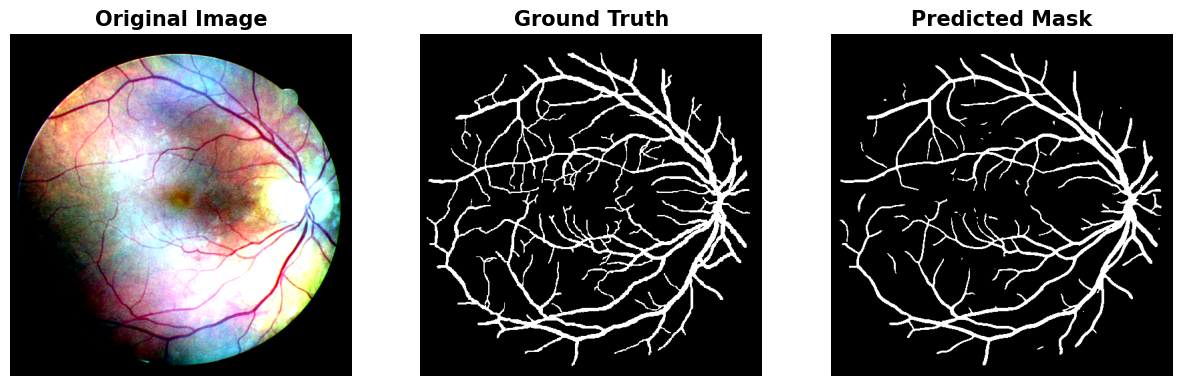

IoU Score after hysteresis thresholding =  0.6759050488471985


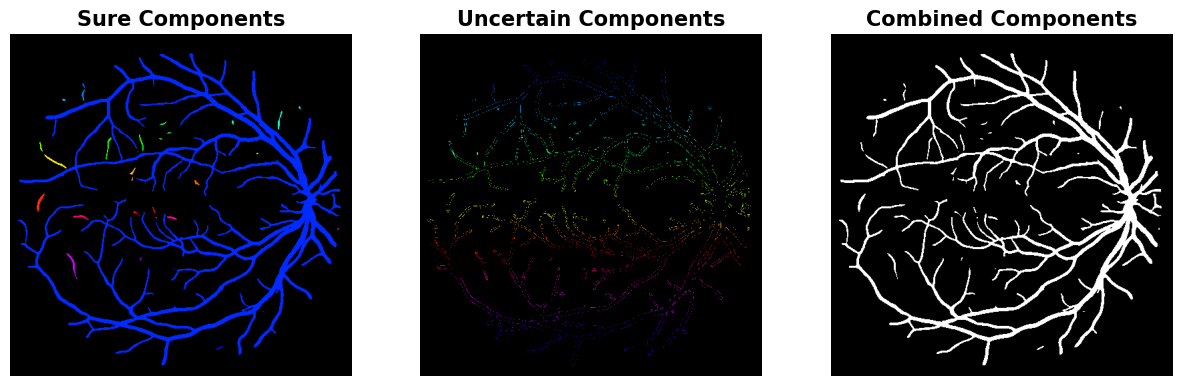

Number of sure components =  29
Number of uncertain components =  2568
IoU Score before hysteresis thresholding =  0.7058343291282654


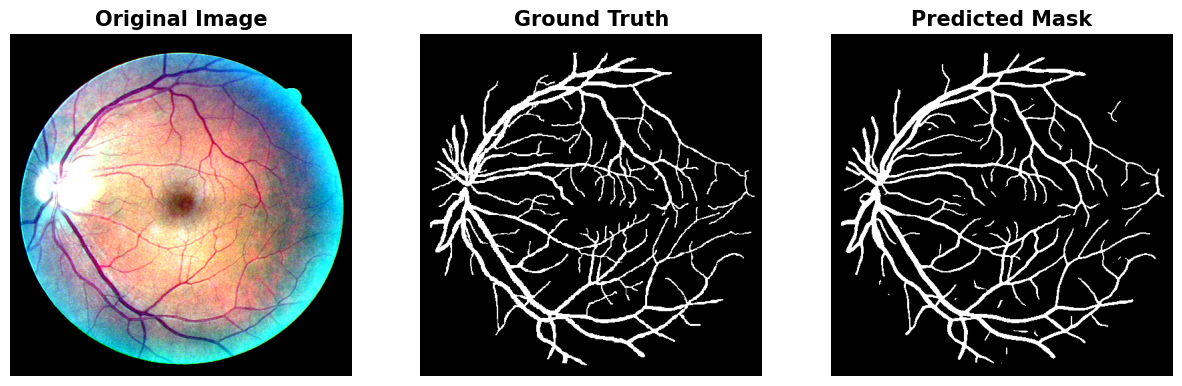

IoU Score after hysteresis thresholding =  0.7050778269767761


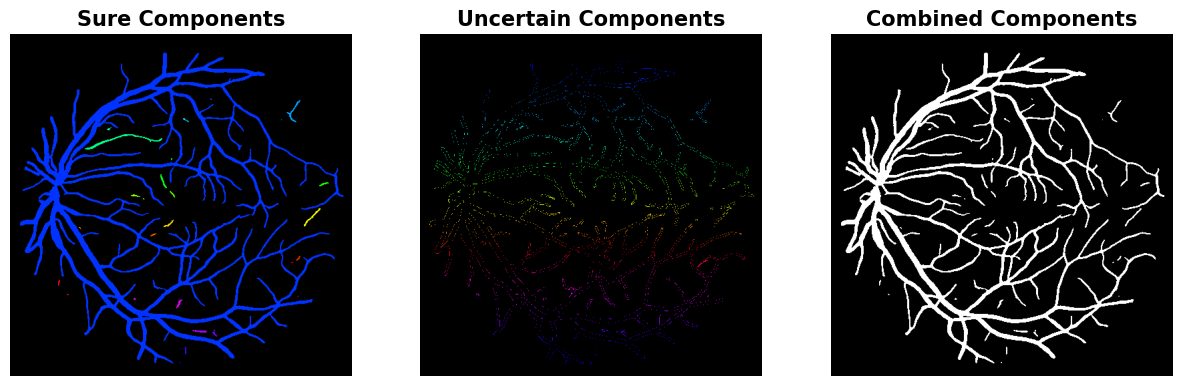

Number of sure components =  28
Number of uncertain components =  2705
IoU Score before hysteresis thresholding =  0.7383984327316284


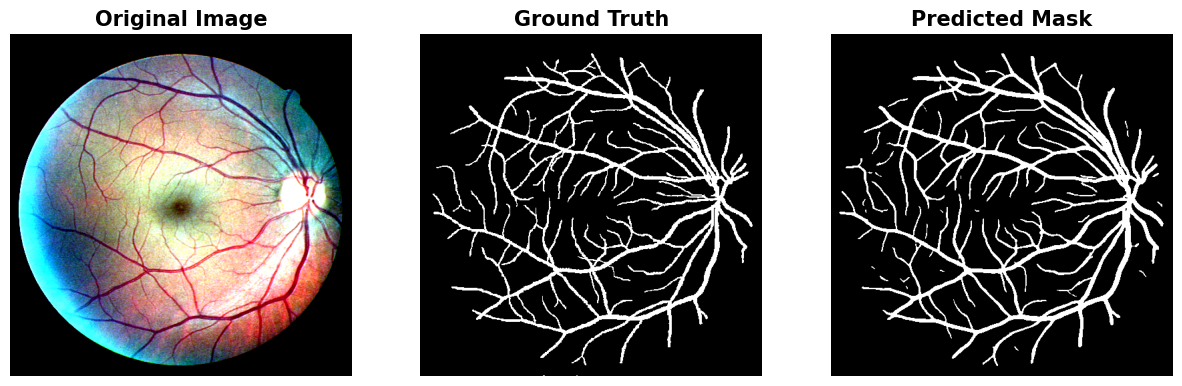

IoU Score after hysteresis thresholding =  0.7299053072929382


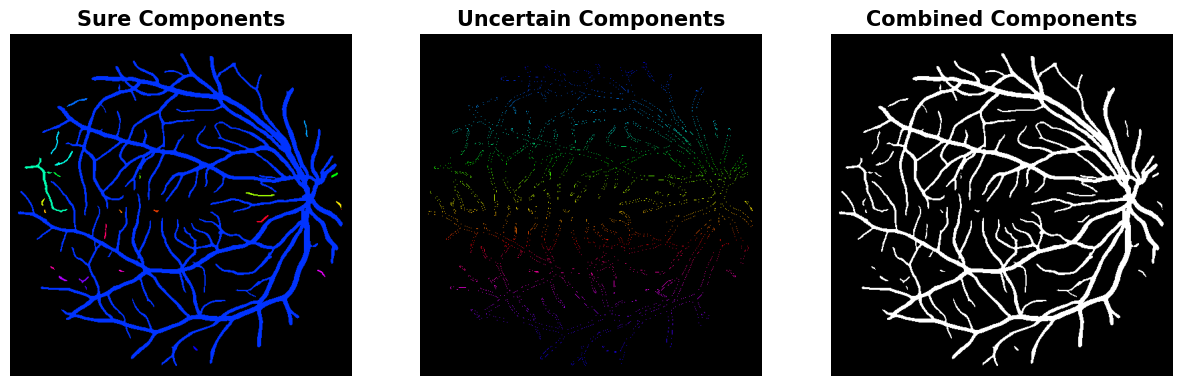

Number of sure components =  31
Number of uncertain components =  2312
IoU Score before hysteresis thresholding =  0.6753510236740112


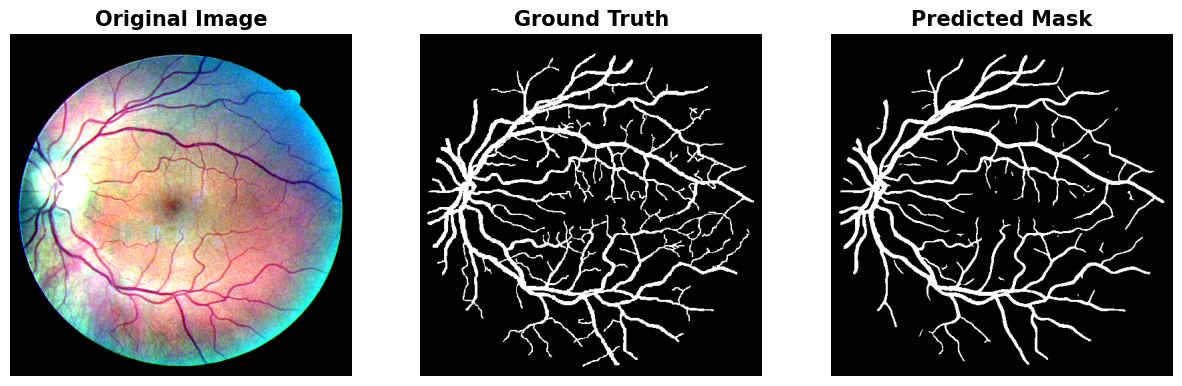

IoU Score after hysteresis thresholding =  0.6823968887329102


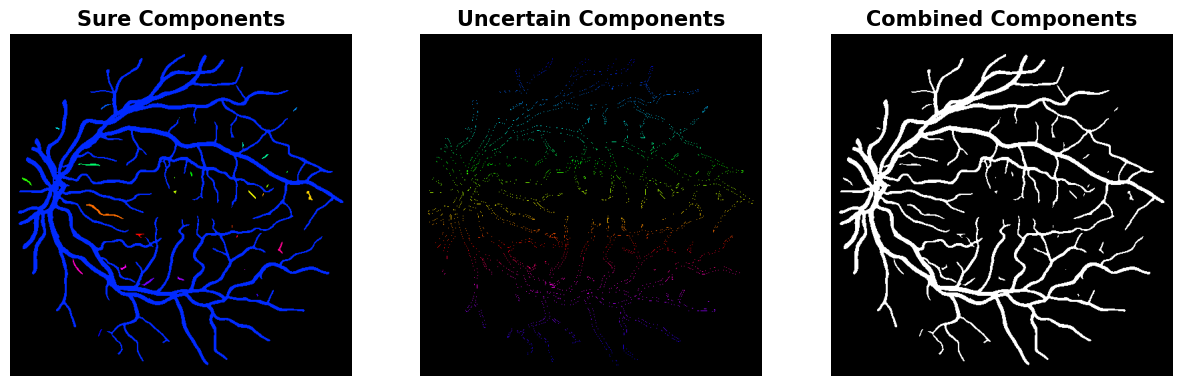

Number of sure components =  48
Number of uncertain components =  2704
IoU Score before hysteresis thresholding =  0.6768151521682739


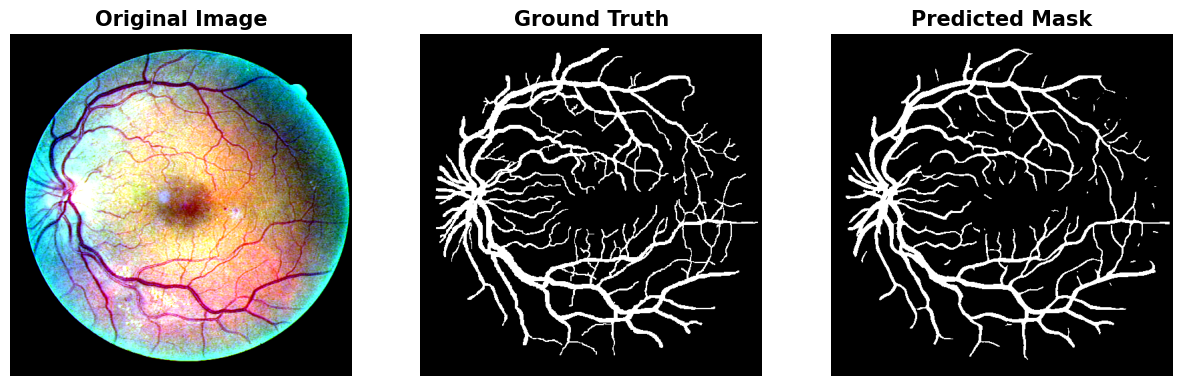

IoU Score after hysteresis thresholding =  0.6812776327133179


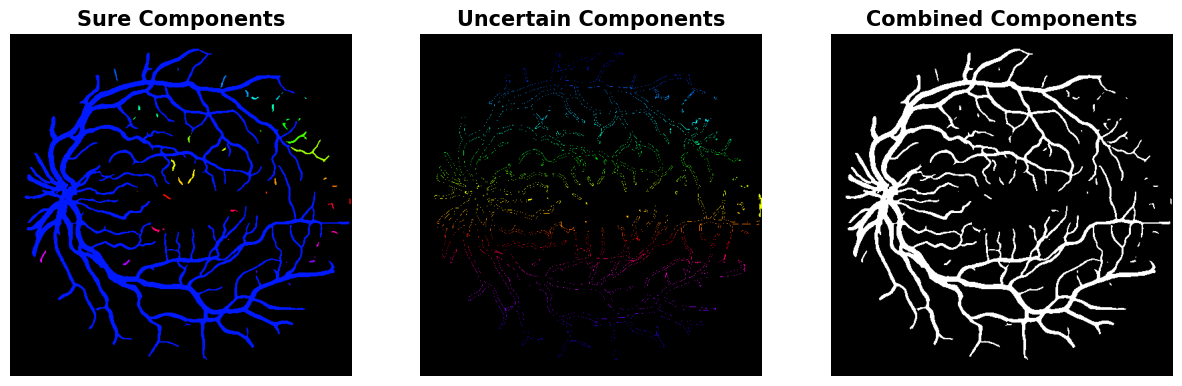

Number of sure components =  31
Number of uncertain components =  2702
IoU Score before hysteresis thresholding =  0.7064743638038635


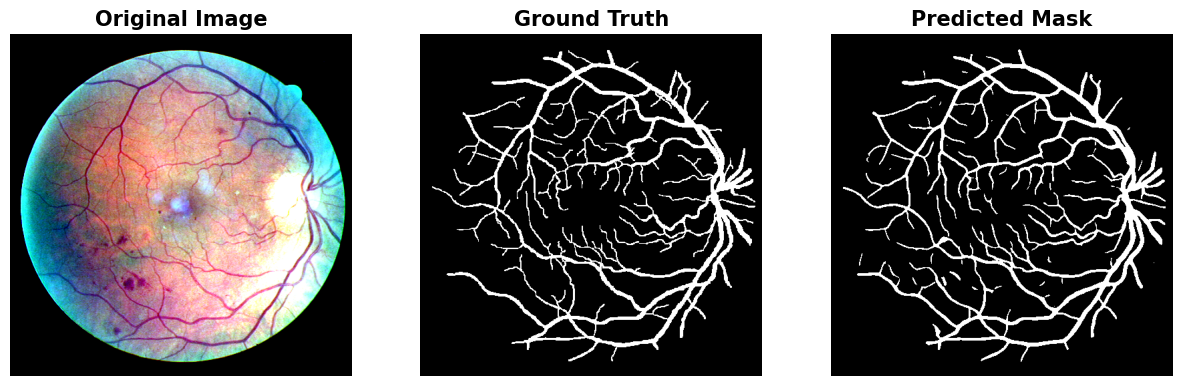

IoU Score after hysteresis thresholding =  0.7044509053230286


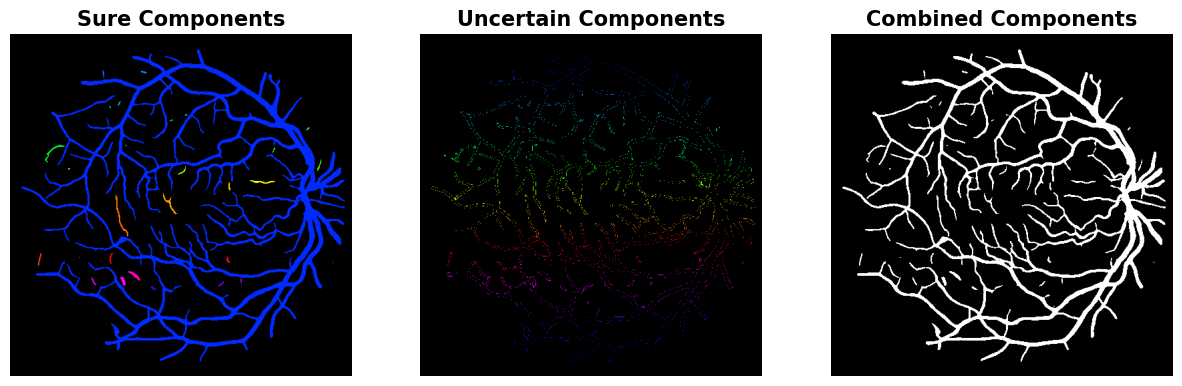

Number of sure components =  28
Number of uncertain components =  2583
IoU Score before hysteresis thresholding =  0.6876556277275085


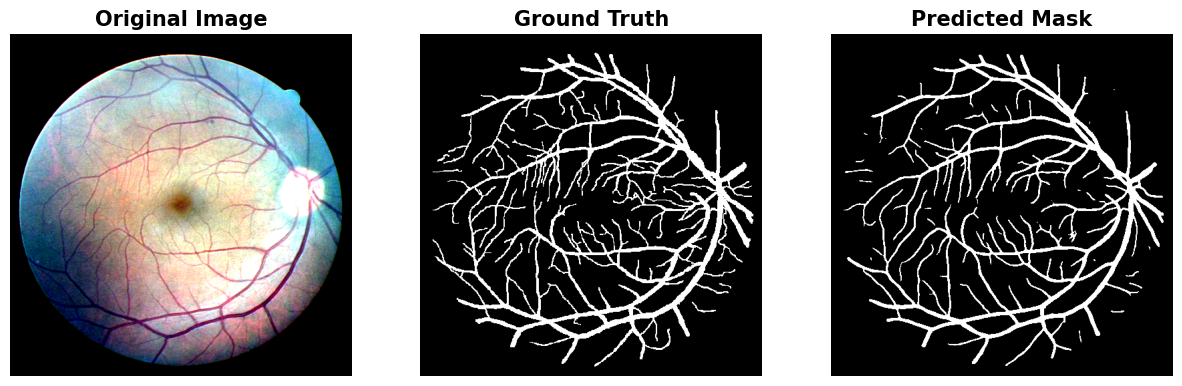

IoU Score after hysteresis thresholding =  0.6955586671829224


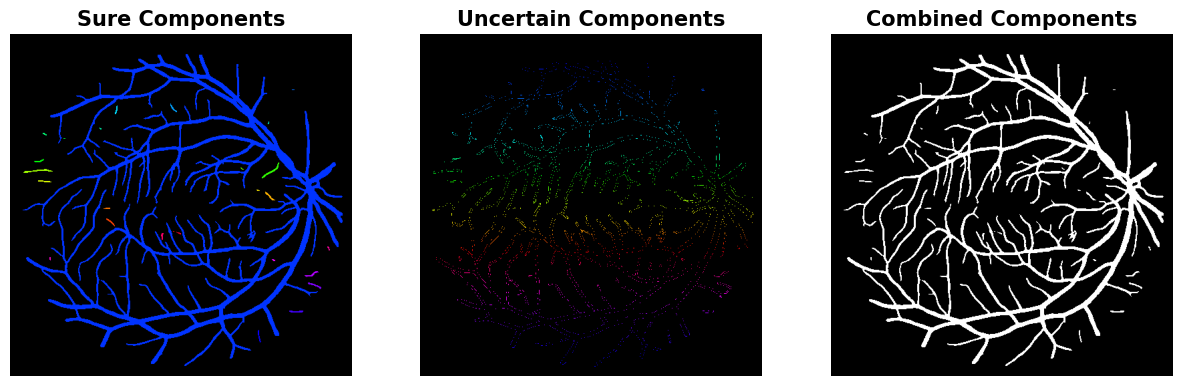

In [32]:
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)
for i in range(show_imgs):
    img, mask = test_dataset[random_list[i]]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    pred = model(img)
    pred = torch.sigmoid(pred)
    mask = mask.round().long()
    
    tp, fp, fn, tn = smp.metrics.get_stats(pred, mask, mode="binary", threshold=0.5) # type: ignore
    iou_before = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()

    img = img.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    pred = pred.squeeze().detach().numpy()
    
    num_sure, sure_labels, num_uncertain, uncertain_labels, combined = connected_components(pred)
    
    print("Number of sure components = ", num_sure)
    print("Number of uncertain components = ", num_uncertain)
    
    print("IoU Score before hysteresis thresholding = ", iou_before)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    pred = pred > 0.5

    ax[0].imshow(img)
    ax[0].set_title("Original Image", fontsize=15, weight="bold")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth", fontsize=15, weight="bold")
    ax[1].axis("off")

    ax[2].imshow(pred, cmap="gray")
    ax[2].set_title("Predicted Mask", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()

    mask = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)
    combined_tensor = torch.tensor(combined).unsqueeze(0).unsqueeze(0).float().to(device)
    
    tp, fp, fn, tn = smp.metrics.get_stats(combined_tensor, mask, mode="binary", threshold=0.5) # type: ignore
    iou_after = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
    print("IoU Score after hysteresis thresholding = ", iou_after)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    label_hue = np.uint8(179 * sure_labels / np.max(sure_labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])  # type: ignore
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0

    ax[0].imshow(labeled_img)
    ax[0].set_title("Sure Components", fontsize=15, weight="bold")
    ax[0].axis("off")
    
    label_hue = np.uint8(179 * uncertain_labels / np.max(uncertain_labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])  # type: ignore
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    ax[1].imshow(labeled_img)
    ax[1].set_title("Uncertain Components", fontsize=15, weight="bold")
    ax[1].axis("off")
    
    ax[2].imshow(combined, cmap="gray")
    ax[2].set_title("Combined Components", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()